<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import networkx as nx
import pandas as pd
import numpy as np

from src.friend_network import FriendNetwork


In [2]:
import json
import pandas as pd

from src.friend import Friend
from src.friend_set import FriendSet

from typing import Dict


class FacebookFriendNetwork(object):
    def __init__(self, friends: FriendSet = None, common_friends: Dict[str, FriendSet] = None):
        self.friends = friends
        self.common_friends = common_friends
        
        if friends is not None and common_friends is not None:
            self.graph = self.calculate_graph()
        else:
            self.graph = None

        print("Facebook Friend Network initialized")
        
    def get_person_friends(self, **person_attributes) -> FriendSet:
        person = self.friends.filter(**person_attributes)
        edges = self.graph.edges(person.user_id)
        return FriendSet([
            ffn.friends.filter(user_id=contact)
            for _, contact in edges
        ])
    
    def get_person_friend_names(self, **attributes):
        friends = self.get_person_friends(**attributes)
        return friends.name

    def load_network(self, filename):
        with open(filename, "r", encoding="utf-8") as file:
            network = json.load(file)

        self.friends = FriendSet([
            Friend(**friend_dict)
            for friend_dict in network["friend_list"]
        ])

        common_friends = {}
        for friend_id, common_friends_dicts in network["common_friends"].items():
            common_friends[friend_id] = [Friend(**friend_dict) for friend_dict in common_friends_dicts]

        self.common_friends = common_friends
        
        self.calculate_graph()
        self.compute_positions()

    def calculate_graph(self):
        self.graph = nx.Graph()
        self.graph.add_nodes_from([(friend.user_id, dict(name=friend.name)) for friend in self.friends])
        self.graph.add_edges_from(self._get_network_edges())
    
    def _get_network_edges(self):
        friends_info = self.get_friends_info()

        edges = []
        for friend_id, common_friends in self.common_friends.items():
            edges += [(
                friend_id,
                friends_info.iloc[(friends_info["link"] == friend.link).idxmax()].user_id
            ) for friend in common_friends]

        return edges

    def get_friends_info(self):
        return pd.DataFrame([vars(friend) for friend in self.friends])
    
    def filter_biggest_component(self):
        biggest_component_nodes = max(nx.connected_components(self.graph), key=len)
        self.graph = self.graph.subgraph(biggest_component_nodes)
        self.compute_positions()
        
    def compute_positions(self, layout=nx.spring_layout):
        self.node_positions = layout(self.graph)
        
    def communities_to_node_community_map(self, communities):
        node_community_map = {}
        for i, community in enumerate(communities):
            node_community_map.update({node: i for node in community})
        
        return pd.Series(node_community_map).reindex(self.graph.nodes).fillna(0).astype("int64")
        
    
    def draw_graph(self, node_scores: Dict[str, float] = None, node_communities: Dict[str, int] = None, label_proportion=0.1):
        def get_random_labels(p):
            labels = {}
            for userid, name in nx.get_node_attributes(self.graph, 'name').items():
                if np.random.binomial(1, p) == 1:
                    labels[userid] = name
                    
            return labels
        
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
        
        color = None
        
        if node_scores is not None:
            node_scores = pd.Series(node_scores).loc[list(self.graph.nodes)]
            threshold_quantile = 1 - label_proportion
            nodes_with_score_higher_than_threshold = node_scores[
                node_scores >= node_scores.quantile(threshold_quantile)
            ].index
            labels = {
                node: self.graph.nodes[node]["name"]
                for node in nodes_with_score_higher_than_threshold
            }
            color = node_scores
        else:
            labels = get_random_labels(label_proportion)
            if node_communities is not None:
                node_community_map = self.communities_to_node_community_map(node_communities)
                color = cm.get_cmap('Paired')(node_community_map.values)
            
        return nx.draw(
            self.graph,
            pos=self.node_positions,
            node_size=45,
            node_color=color,
            edge_color=(0, 0, 0, 0.1),
            ax=ax,
            with_labels=True,
            labels=labels
        )



In [5]:
ffn = FriendNetwork()

In [6]:
ffn.load_network("media/networks/chananterohotmail.com.json")
ffn.filter_biggest_component()

c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 31777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 23391 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 33464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 31777 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 23

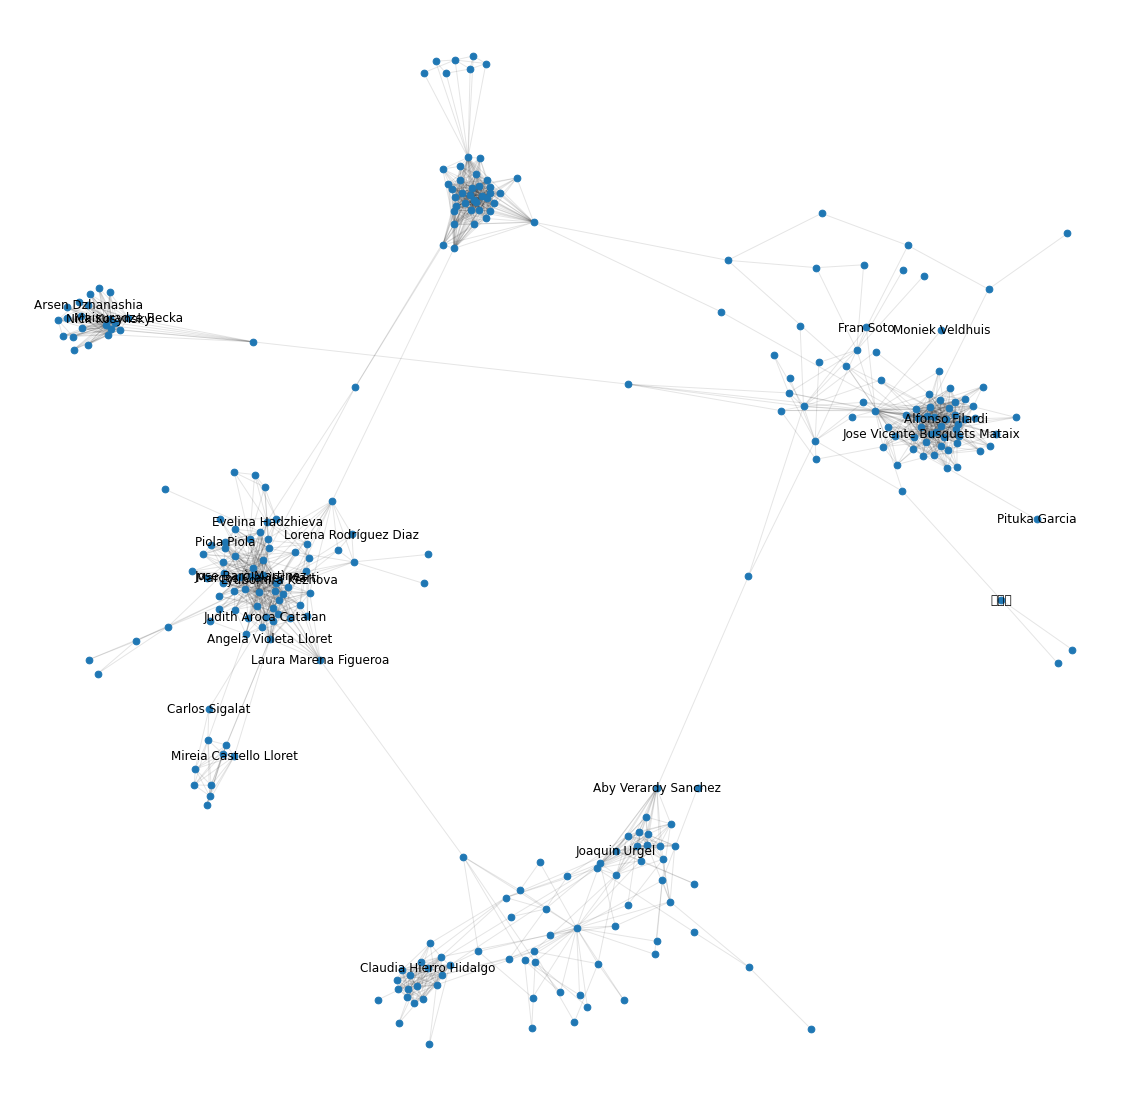

In [7]:
ffn.draw_graph()

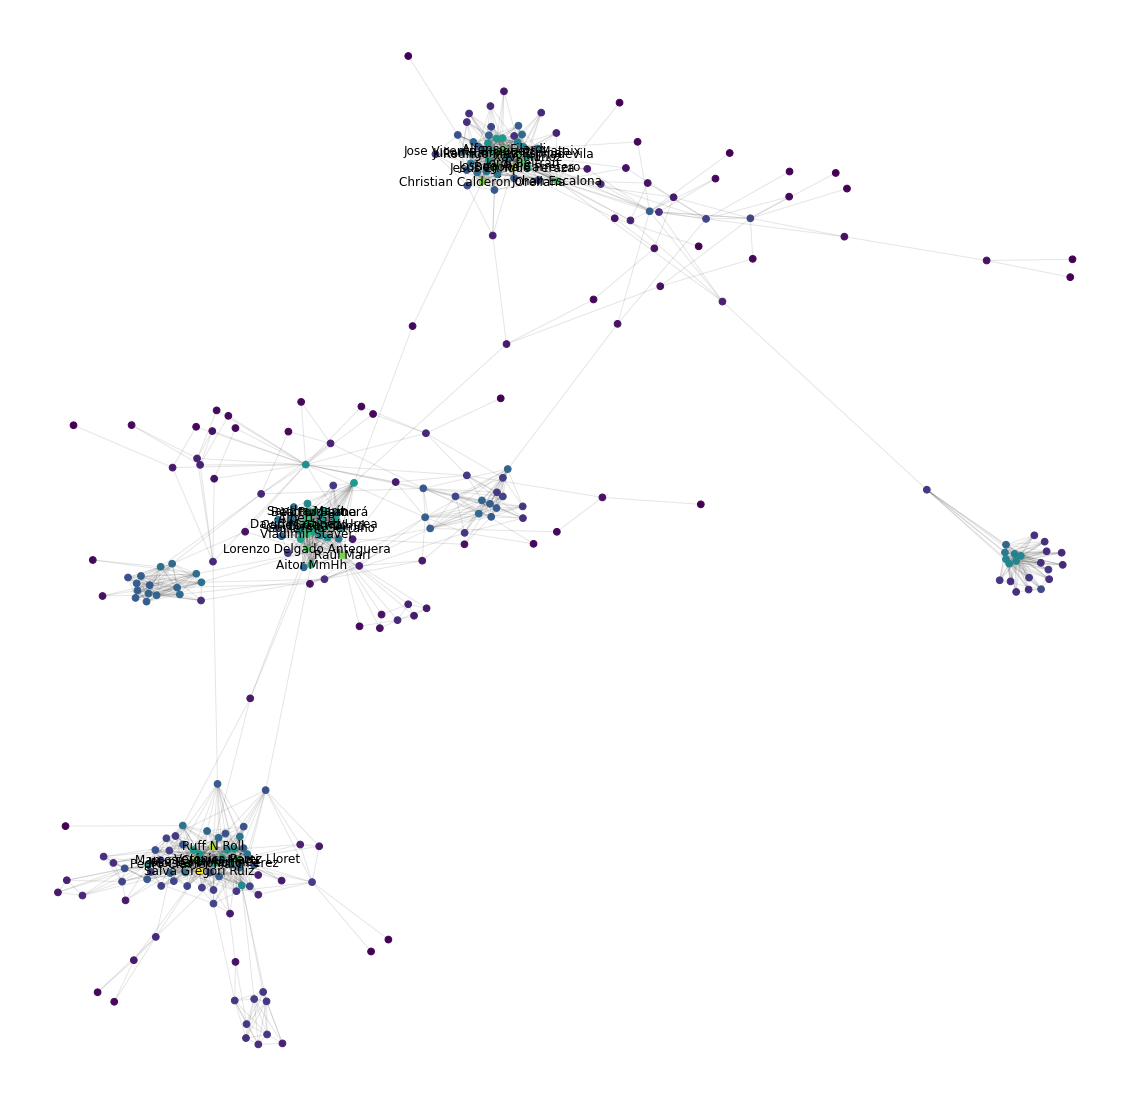

In [6]:
ffn.draw_graph(node_scores=nx.degree_centrality(ffn.graph))

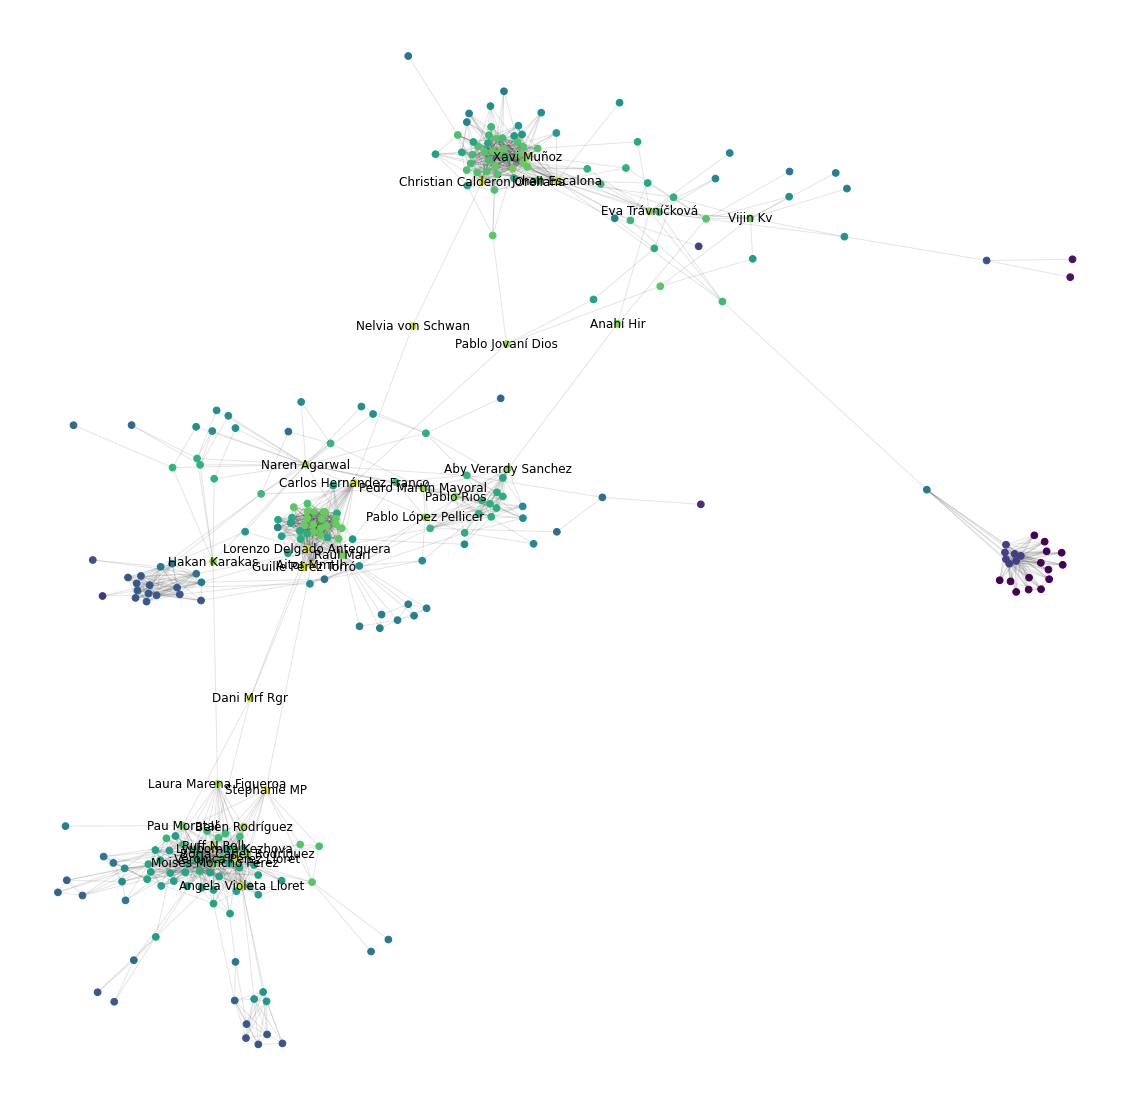

In [7]:
ffn.draw_graph(node_scores=nx.closeness_centrality(ffn.graph))

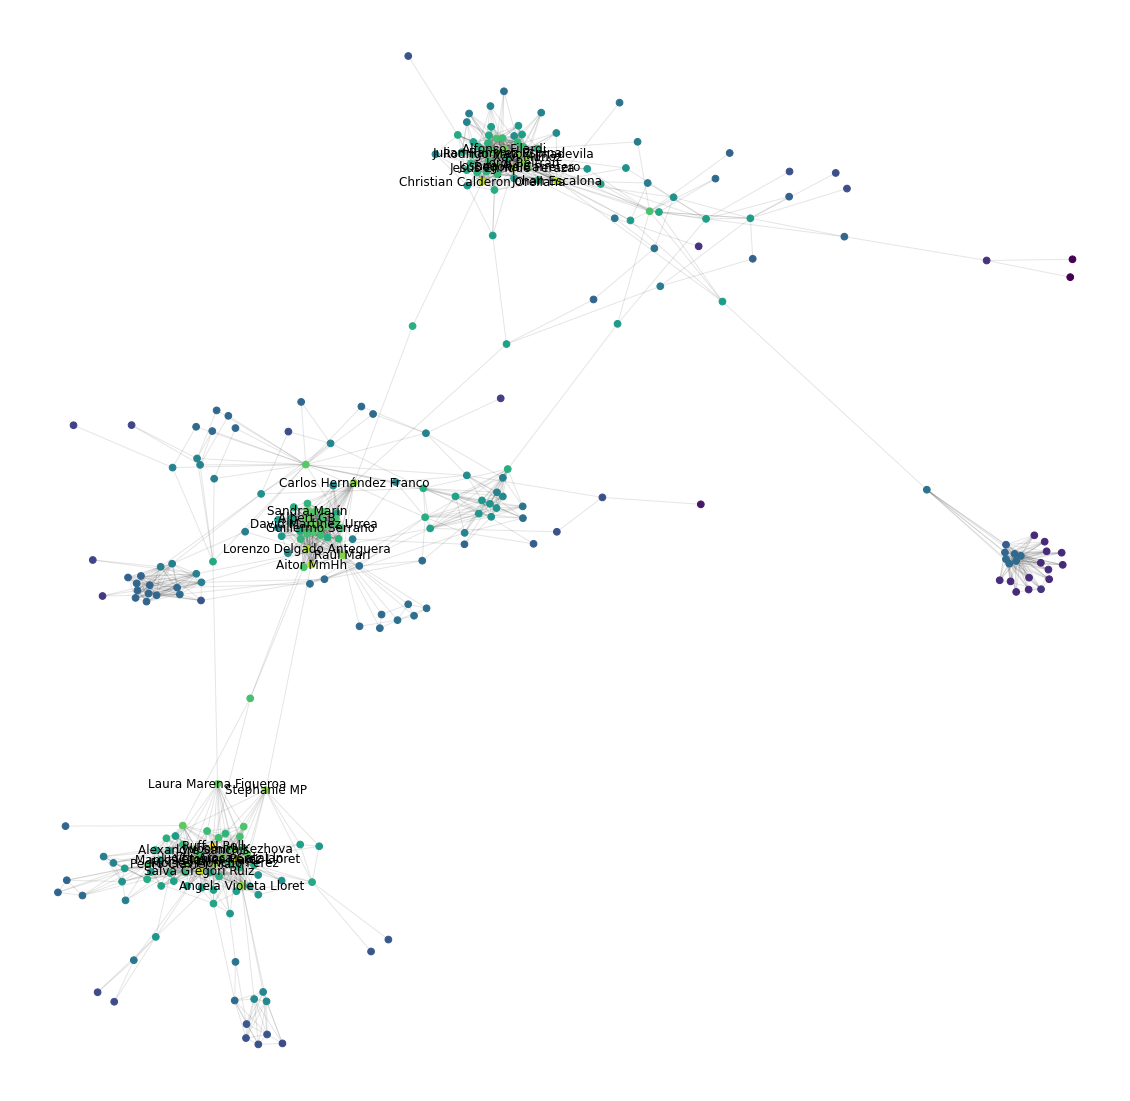

In [8]:
ffn.draw_graph(node_scores=nx.harmonic_centrality(ffn.graph))

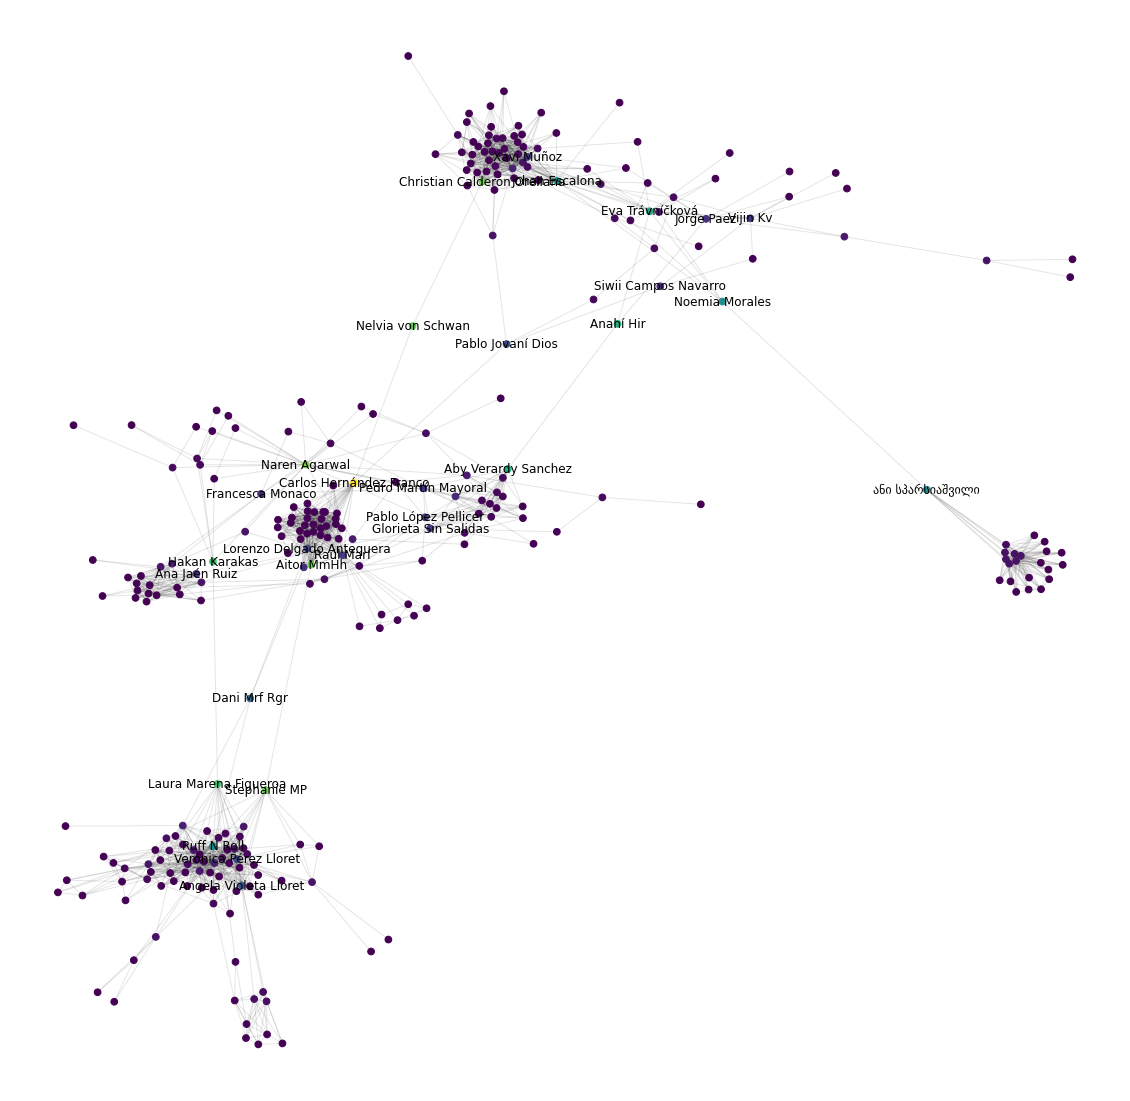

In [9]:
ffn.draw_graph(node_scores=nx.betweenness_centrality(ffn.graph))

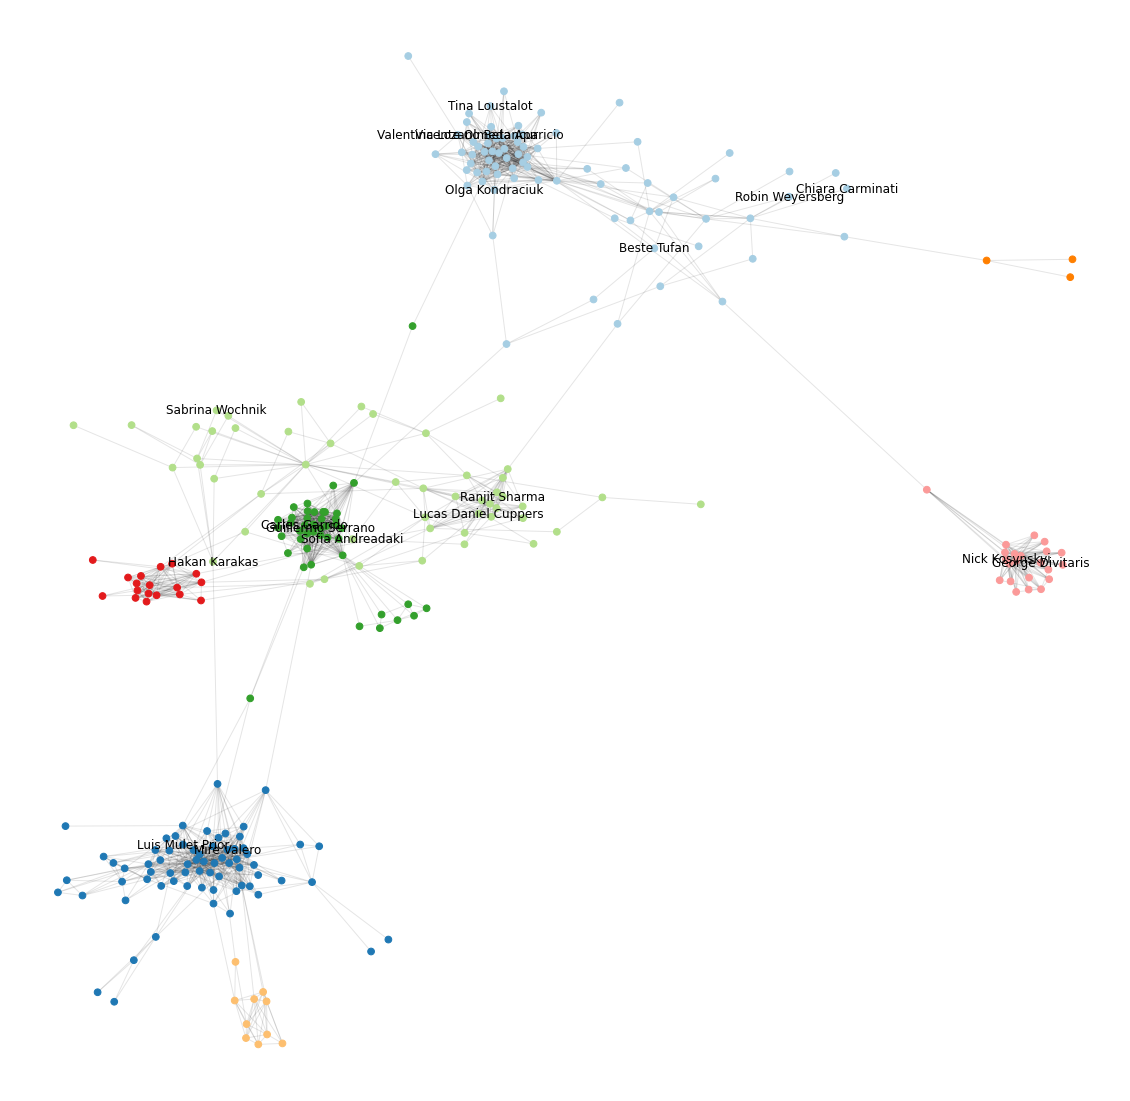

In [10]:
ffn.draw_graph(node_communities=nx.algorithms.community.greedy_modularity_communities(ffn.graph))

c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 31777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 23391 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 33464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 31777 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\chana\pythonvirtualenvironments\facebookfriendnetwork2\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 23

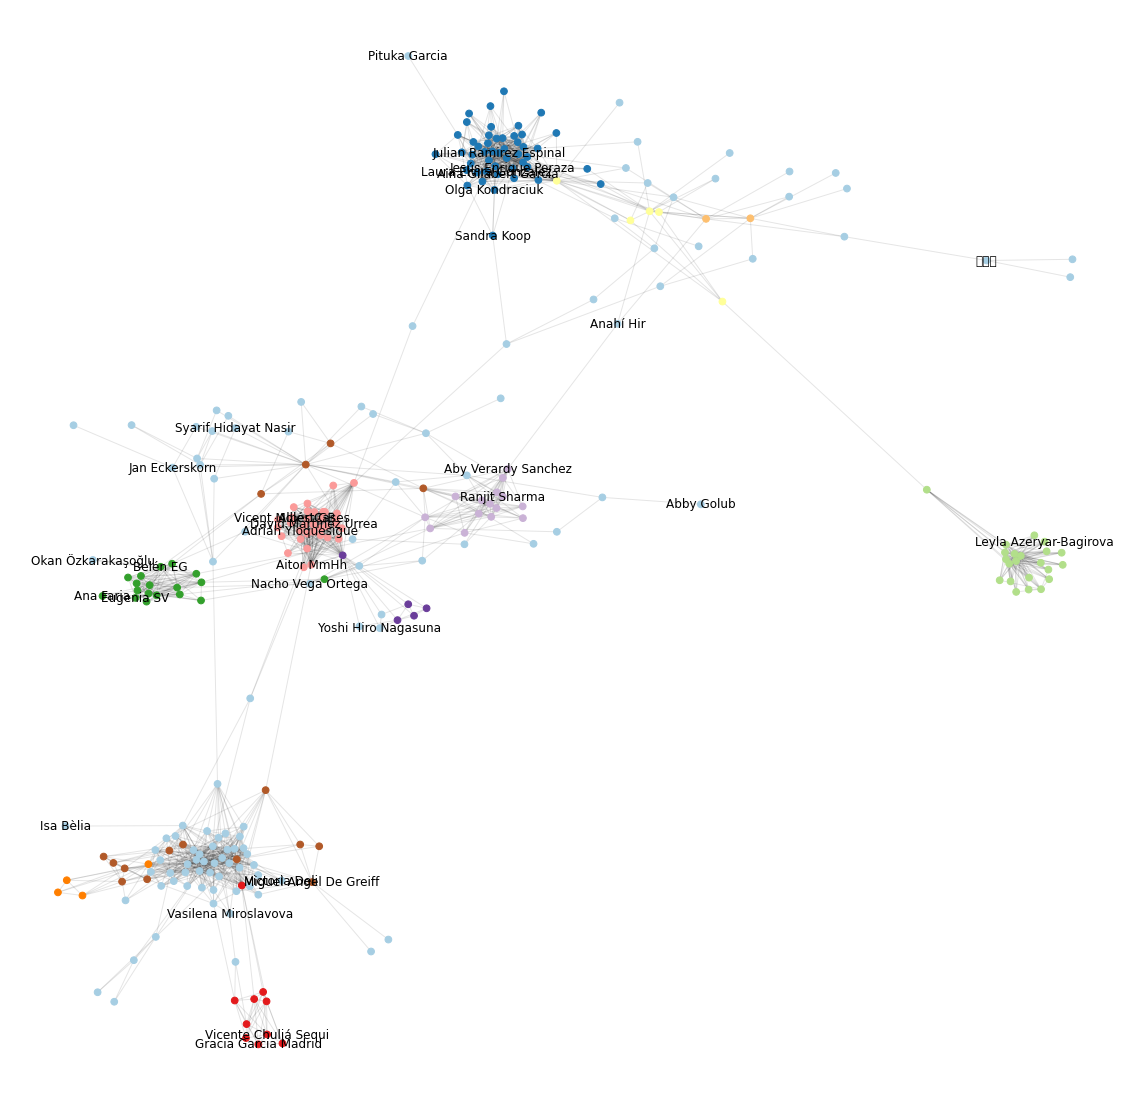

In [11]:
ffn.draw_graph(node_communities=list(nx.algorithms.community.kclique.k_clique_communities(ffn.graph, 4)))